In [1]:
import pandas as pd
import librosa
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

# Import for local library
import os
import sys
sys.path.insert(0, os.path.abspath('../lib'))
import util

import soundfile as sf




C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
df = pd.read_csv('../../SQLqueries/fine_path_species_label.csv', header = None)
df.columns = ['label_id', 'audio_id', 'fine_start_time', 'fine_end_time', 'species', 'sound_type', 'path']
df = util.remove_label_bug(df, verbose=0)

In [3]:
df_all = pd.read_csv('../../SQLqueries/fine_mosquito_species_inc_none.csv', header = None)
df_all.columns = ['label_id', 'audio_id', 'fine_start_time', 'fine_end_time', 'species', 'sound_type', 'path']
df_all = util.remove_label_bug(df_all, verbose=1)

Old dataframe length: 3341
New dataframe length: 3257


In [4]:
df_noise = pd.read_csv('../../SQLqueries/fine_path_non_mosquito.csv', header = None)
df_noise.columns = ['label_id', 'audio_id', 'fine_start_time', 'fine_end_time', 'species', 'sound_type', 'path']
df_noise = util.remove_label_bug(df_noise, verbose=1)

Old dataframe length: 1063
New dataframe length: 1059


In [5]:
# Append larvae recordings from dataframe to mosquito instead of noise.
#This is a hotfix to merge the two types from the database
# Note that species information has gone missing for this field.
df = df.append(df_noise[df_noise["sound_type"] == " 'larvae'"])

In [6]:
# Select noise data as labelled entries of all except larvae type
df_noise = df_noise[df_noise["sound_type"] != " 'larvae'"]

In [7]:
# See list of paths used in dataframe
print('Dataframe original:', df["path"].unique())
print('Dataframe noise:', df_noise["path"].unique())

Dataframe original: [" '/CDC/sounds/CDC_Ae-albopictus_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-albimanus_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-arabiensis_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-atroparvus_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-coluzzii_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-dirus_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-farauti_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-freeborni_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-funestus_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-merus_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-minimus_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-quadriannulatus_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-quadrimaculatus_labelled_800.wav'"
 " '/Culex/sounds/R4_cleaned recording_12-10-17.wav'"
 " '/CDC/sounds/CDC_An-sinensis_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-stephensi_labelled_800.wav'"
 " '/CDC/sounds/CDC_Cx-quinquefasciatus_labelled_800.wav'"
 " '/CDC/sounds/CDC_Cx-tarsalis_labelled_800.wav'"
 " '/Culex/sounds/R4_cleaned recordi

In [8]:
# Choose to train on data which contains the strings below in the path filename for true holdout data split

index_list_train = []
index_list_test = []
for index, path in enumerate(df["path"]):

# Logic used before 18/11 to train all the pickled models saved    

    if 'Thai' not in path and 'Culex/sounds' not in path:
        index_list_train.append(index)
    else:
        # Removing duplicate entries for "xxxx.wav" and "June/Julyxxx_COW.wav"
        if 'cow' not in path and 'COW' not in path and 'HLC' not in path and 'hlc' not in path and 'June' not in path:
            index_list_test.append(index)
            
# # Logic used as of 18/11 to train a classifier on all data
#     if 'cow' not in path and 'COW' not in path and 'HLC' not in path and 'hlc' not in path and 'June' not in path:
#         index_list_train.append(index)


            

print('Number of clips chosen for training:', len(index_list_train))
print('Number of clips chosen for testing:', len(index_list_test))

df_train = df.iloc[index_list_train]
df_test = df.iloc[index_list_test]

Number of clips chosen for training: 533
Number of clips chosen for testing: 1438


In [9]:
# Choose to train on noise which contains the strings below in the path filename for true holdout data split

index_list_train = []
index_list_test = []
# for index, path in enumerate(df_noise["path"]):
#     if 'Thai' not in path and 'Culex/sounds/00' not in path:
#         index_list_train.append(index)
#     else:
#         index_list_test.append(index)
        
# Logic used as of 18/11 to train a classifier on all data
for index, path in enumerate(df_noise["path"]):
    index_list_train.append(index)

print('Number of clips chosen for training:', len(index_list_train))
print('Number of clips chosen for testing:', len(index_list_test))

df_train_noise = df_noise.iloc[index_list_train]
df_test_noise = df_noise.iloc[index_list_test]

Number of clips chosen for training: 924
Number of clips chosen for testing: 0


In [10]:
print(len(np.where(df_all['fine_end_time'] - df_all['fine_start_time']>1)[0]))
print(len(np.where(df_all['fine_end_time'] - df_all['fine_start_time']<1)[0]))

2635
621


In [11]:
# See list of paths used in train/test/noise dataframes
print('Train:', df_train["path"].unique())
print('Test:', df_test["path"].unique())
print('Train noise:', df_train_noise["path"].unique())
print('Test noise:', df_test_noise["path"].unique())

Train: [" '/CDC/sounds/CDC_Ae-albopictus_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-albimanus_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-arabiensis_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-atroparvus_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-coluzzii_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-dirus_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-farauti_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-freeborni_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-funestus_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-merus_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-minimus_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-quadriannulatus_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-quadrimaculatus_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-sinensis_labelled_800.wav'"
 " '/CDC/sounds/CDC_An-stephensi_labelled_800.wav'"
 " '/CDC/sounds/CDC_Cx-quinquefasciatus_labelled_800.wav'"
 " '/CDC/sounds/CDC_Cx-tarsalis_labelled_800.wav'"
 " '/LSTMH/sounds/LSTMH telinga audio - edited and labelled.wav'"
 " '/CDC/sounds/CDC_Ae-aegypti_labell

In [12]:
x_s_tr, x_s_tr_l = util.get_wav_for_df(df_train, 8000)
x_s_te, x_s_te_l = util.get_wav_for_df(df_test, 8000)
x_n_tr, x_n_tr_l = util.get_wav_for_df(df_train_noise, 8000)

## Augmenting dataset with extra data and splitting
It now remains to decide on a way of splitting the data for a comprehensive training and test set. We can use cross-validation on a subset of the training set to further select model hyperparameters. We will explictly split into:
* Train signal, train noise
* Test signal, test noise

In [13]:
noise_path_names_Culex = [ '/Culex/sounds/0001_norm.wav', '/Culex/sounds/0002_norm.wav', '/Culex/sounds/0003_norm.wav',
 '/Culex/sounds/0004_norm.wav', '/Culex/sounds/0005_norm.wav', '/Culex/sounds/0006_norm.wav', '/Culex/sounds/0007_norm.wav',
 '/Culex/sounds/0008_norm.wav', '/Culex/sounds/0009_norm.wav', '/Culex/sounds/0010_norm.wav', '/Culex/sounds/0011_norm.wav',
 '/Culex/sounds/0012_norm.wav', '/Culex/sounds/0013_norm.wav', '/Culex/sounds/0014_norm.wav', '/Culex/sounds/0015_norm.wav',
 '/Culex/sounds/0016_norm.wav', '/Culex/sounds/0017_norm.wav', '/Culex/sounds/0018_norm.wav', '/Culex/sounds/0019_norm.wav',
 '/Culex/sounds/0020_norm.wav', '/Culex/sounds/0025_norm.wav', '/Culex/sounds/0041_norm.wav', '/Culex/sounds/0042_norm.wav',
 '/Culex/sounds/0043_norm.wav', '/Culex/sounds/0044_norm.wav', '/Culex/sounds/0046_norm.wav', '/Culex/sounds/0047_norm.wav', 
 '/Culex/sounds/0051_norm.wav', '/Culex/sounds/0053_norm.wav', '/Culex/sounds/0054_norm.wav', '/Culex/sounds/0056_norm.wav']

x_n_add_Culex, s_n_add_Culex = util.get_wav_for_path(noise_path_names_Culex, sr=8000)
x_n_add_CDC, s_n_add_CDC = util.get_wav_for_path(['/CDC/sounds/background.wav'], sr=8000)


# Confirmed noise (Dav):
dav_noise = ['/Experiments/sounds/noise0.wav', '/Experiments/sounds/noise1.wav', '/Experiments/sounds/noise2.wav', 
             '/Experiments/sounds/noise3.wav', '/Experiments/sounds/noise4.wav', '/Experiments/sounds/noise5.wav', 
             '/Experiments/sounds/noise6.wav']

x_n_add_dav, s_n_add_dav = util.get_wav_for_path(dav_noise, sr=8000)


In [14]:
# Important: need to filter out duplicates. MUST UPDATE df_all
x_n_Thai, s_n_Thai = util.get_noise_wav_for_df(df_all, ['Thai'], 0.75, 8000, verbose=0)

# x_n_Thai_July, s_n_Thai_July = get_noise_wav_for_df(df, ['July'], 8000)
x_n_Culex, s_n_Culex = util.get_noise_wav_for_df(df, ['Culex/sounds/00'], 0.00, 8000, verbose=0)


['Thai']
['Culex/sounds/00']


In [15]:
# Print unique species in set(s)
print('Training species')
print(df_train["species"].unique())
print('Testing species')
print(df_test["species"].unique())

Training species
[" 'ae albopictus'" " 'an albimanus'" " 'an arabiensis'"
 " 'an atroparvus'" " 'an coluzzii'" " 'an dirus'" " 'an farauti'"
 " 'an freeborni'" " 'an funestus'" " 'an merus'" " 'an minimus'"
 " 'an quadriannulatus'" " 'an sinensis'" " 'an stephensi'"
 " 'culex quinquefasciatus'" " 'culex tarsalis'"
 " 'toxorhynchites brevipalpis'" " 'an gambiae'" " 'ae aegypti'"]
Testing species
[" 'culex quinquefasciatus'" " 'an dirus'" " 'an harrisoni'"
 " 'an minimus'" " 'an maculatus'" " 'an barbirostris'" ' None']


## Split signal
We hold out some data to split. No obvious split currently so will wing it.

In [16]:
# Run a few files to verify
ipd.Audio(x_n_Thai[48], rate = 8000)


### Features for signal from query

In [17]:
X_s_tr = util.get_feat(x_s_tr, sr=8000, feat_type='log-mel', flatten=False)
X_s_tr_CNN = util.reshape_feat(X_s_tr, win_size=20, step_size=20)

X_s_te = util.get_feat(x_s_te, sr=8000, feat_type='log-mel', flatten=False)
X_s_te_CNN = util.reshape_feat(X_s_te, win_size=20, step_size=20 )

X_n_tr = util.get_feat(x_n_tr, sr=8000, feat_type='log-mel', flatten=False)
X_n_tr_CNN = util.reshape_feat(X_n_tr, win_size=20, step_size=20 )


### Features for noise from Culex Q home data and Thai

In [18]:
X_n_Thai = util.get_feat(x_n_Thai, sr=8000, feat_type='log-mel', flatten=False)
X_n_Thai_CNN = util.reshape_feat(X_n_Thai, win_size=20, step_size=20)

X_n_Culex = util.get_feat(x_n_Culex, sr=8000, feat_type='log-mel', flatten=False)
X_n_Culex_CNN = util.reshape_feat(X_n_Culex, win_size=20, step_size=20)


### Features for noise from CDC and remaining Culex data, and other noise


In [19]:
X_n_add_Culex = util.get_feat(x_n_add_Culex, sr=8000, feat_type='log-mel', flatten=False)
X_n_add_Culex_CNN = util.reshape_feat(X_n_add_Culex, win_size=20, step_size=20)


In [20]:
X_n_add_CDC = util.get_feat(x_n_add_CDC, sr=8000, feat_type='log-mel', flatten=False)
X_n_add_CDC_CNN = util.reshape_feat(X_n_add_CDC, win_size=20, step_size=20)

X_n_add_dav = util.get_feat(x_n_add_dav, sr=8000, feat_type='log-mel', flatten=False)
X_n_add_dav_CNN = util.reshape_feat(X_n_add_dav, win_size=20, step_size=20)


### Concatenate and trim+shuffle for balanced signal and noise

In [21]:
# Data concatenation for CNN:
spec_matrix_db = np.vstack([X_s_tr_CNN, X_s_te_CNN, X_n_Thai_CNN, X_n_tr_CNN, X_n_add_dav_CNN, X_n_Culex_CNN, X_n_add_CDC_CNN])
end_sample = len(X_s_tr_CNN) + len(X_s_te_CNN)
y = np.zeros(len(spec_matrix_db))
y[:end_sample] = 1

In [58]:
from sklearn.model_selection import train_test_split


# Deep learning
# Keras-related imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution1D, MaxPooling2D, Convolution2D
from keras import backend as K
# K.set_image_dim_ordering('th')
from keras.callbacks import ModelCheckpoint
from keras.callbacks import RemoteMonitor
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D


# Data concatenation for CNN:
spec_matrix_db = np.vstack([X_s_tr_CNN, X_s_te_CNN, X_n_Thai_CNN, X_n_tr_CNN, X_n_add_dav_CNN, X_n_Culex_CNN, X_n_add_CDC_CNN])
end_sample = len(X_s_tr_CNN) + len(X_s_te_CNN)
y = np.zeros([len(spec_matrix_db), 2])
y[:end_sample,1] = 1
y[end_sample:,0] = 1
X_train, X_test, y_train, y_test = train_test_split(spec_matrix_db, np.array(y), test_size=0.33,
                                                    random_state=42)
# Normalise by statistics of training data
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)
X_test_norm = (X_test - np.mean(X_train))/np.std(X_train)
X_train_tf = X_train_norm
X_test_tf = X_test_norm

################################ CONVOLUTIONAL NEURAL NETWORK ################################
## NN parameters
class_weight = {0: 1.,
                1: 1.,
                }
input_shape = (1, X_train_tf.shape[2], X_train_tf.shape[-1])

model = Sequential()
n_dense = 128
nb_classes = 2
# number of convolutional filters
nb_conv_filters = 32
# num_hidden = 236
nb_conv_filters_2 = 64
convout1 = Activation('relu')
convout2 = Activation('relu')

model.add(Conv2D(nb_conv_filters, kernel_size = (3,3),
     activation = 'relu', padding = 'valid', strides = 1,
     input_shape = input_shape))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(nb_conv_filters_2, kernel_size = (3,3),
     activation = 'relu', padding = 'valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(nb_conv_filters_2, kernel_size = (5,5),
#      activation = 'relu', padding = 'valid'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))  
model.add(Flatten())
# Shared between MLP and CNN:
model.add(Dense(n_dense, activation='relu'))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
                optimizer='adadelta',
                metrics=['accuracy'])

model.fit(x=X_train_tf, y=y_train, batch_size=None, epochs=20, verbose=1, callbacks=None, validation_split=0.0,
          validation_data=None,
          shuffle=True, class_weight=class_weight, sample_weight=None, initial_epoch=0,
          steps_per_epoch=None, validation_steps=None)


Epoch 1/20
13803/13803 [==============================] - 2s 146us/step - loss: 0.1080 - accuracy: 0.9582
Epoch 2/20
13803/13803 [==============================] - 2s 134us/step - loss: 0.0634 - accuracy: 0.9788
Epoch 3/20
13803/13803 [==============================] - 2s 135us/step - loss: 0.0543 - accuracy: 0.9819
Epoch 4/20
13803/13803 [==============================] - 2s 138us/step - loss: 0.0451 - accuracy: 0.9842
Epoch 5/20
13803/13803 [==============================] - 2s 138us/step - loss: 0.0380 - accuracy: 0.9865
Epoch 6/20
13803/13803 [==============================] - 2s 134us/step - loss: 0.0305 - accuracy: 0.9887
Epoch 7/20
13803/13803 [==============================] - 2s 136us/step - loss: 0.0278 - accuracy: 0.9907
Epoch 8/20
13803/13803 [==============================] - 2s 134us/step - loss: 0.0248 - accuracy: 0.9911
Epoch 9/20
13803/13803 [==============================] - 2s 136us/step - loss: 0.0222 - accuracy: 0.9906
Epoch 10/20
13803/13803 [=====================

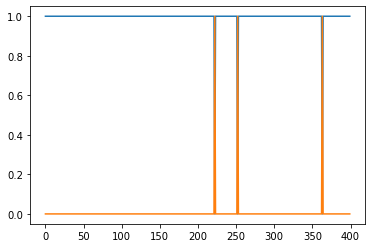

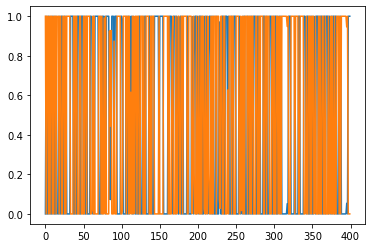

In [61]:
plt.plot(model.predict_proba(X_test[:400]))
plt.show()
plt.plot(model.predict_proba(X_test_tf[:400]))
plt.show()

In [53]:
score, acc = model.evaluate(X_test, y_test)

6799/6799 [==============================] - 0s 61us/step


In [54]:
print(score, acc)

0.05306452322796699 0.990439772605896


In [59]:
model.save('firstCNN_norm.h5')

In [60]:
# Save normalisation data:
# X_test_norm = (X_test - np.mean(X_train))/np.std(X_train)

with open('mean_norm.npy', 'wb') as f:
    np.save(f, np.mean(X_train))
with open('std_norm.npy', 'wb') as f:
    np.save(f, np.std(X_train))


In [ ]:
# # Dataset split 18/11: WHOLE database of signal and noise
# print(len(X_s_tr))
# print(len(X_n_tr))
# print(len(X_n_Thai))
# print(len(X_n_Culex))
# print(len(X_n_add_Culex))
# print(len(X_n_add_CDC))
# print(len(X_n_add_dav))

# X_n_db =  np.vstack([X_n_tr, X_n_Thai, X_n_Culex, X_n_add_Culex, X_n_add_CDC, X_n_add_dav])
# X_tr = np.vstack([X_s_tr, X_n_db])



In [ ]:
# Used before 18/11/20 to train
X_tr = np.vstack([X_s_tr, shuffle(X_n_tr)[:len(X_s_tr)]])
# X_tr = X_tr[:,1:]
print(np.shape(X_tr))

In [ ]:
# X_s_te = X_s_te[:,1:]

In [ ]:
# X_tr = np.vstack([X_s_tr, shuffle(X_n_tr)[:len(X_s_tr)]])
# X_tr = X_tr[:,1:]
y_tr = np.zeros(len(X_tr))
y_tr[:len(X_s_tr)] = 1
plt.plot(y_tr)
y_te = np.hstack([np.ones(len(X_s_te)), np.zeros(len(X_n_Culex)), np.zeros(len(X_n_add_Culex))])
y_te = np.ones(len(X_s_te))

# Train model

In [ ]:
clf = RandomForestClassifier(max_depth=5, random_state=0, verbose=0, n_jobs=-1)
# clf = SVC(verbose=2, probability=False)
clf.fit(X_tr,y_tr)

In [ ]:
accuracy_score(clf.predict(X_tr), y_tr)

In [ ]:
accuracy_score(clf.predict(X_tr), y_tr)

In [ ]:
# from sklearn.neural_network import MLPClassifier

# clf = MLPClassifier(random_state=1, hidden_layer_sizes=(128,128,64))
# clf.fit(X_tr, y_tr)

In [ ]:
print lol

# Save classifier

In [ ]:
import pickle

with open('clf_log-mel-dB_depth5.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
preds = clf.predict(np.vstack([X_s_te]))
print('Signal acc', accuracy_score(y_te, preds))

plt.figure()
plt.plot(preds, '.')
plt.plot(y_te)

preds = clf.predict(np.vstack([X_n_Culex, X_n_add_Culex]))
y_te = np.hstack([np.zeros(len(X_n_Culex)), np.zeros(len(X_n_add_Culex))])

print('Noise acc', accuracy_score(y_te, preds))
plt.figure()
plt.plot(preds, '.')
plt.plot(y_te)


# Evaluate Model

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

In [ ]:
_,_ = util.df_metadata(df_train, plot=True, filepath='Graphs/Train2.pdf')
_,_ = util.df_metadata(df_test, plot=True, filepath='Graphs/Test2.pdf')


In [ ]:
print('Test set processing (i) ...')
species_wav_dict = {}
for species in df_test["species"].unique():
    x, signal_length = util.get_wav_for_df(df_test[df_test["species"] == species], 8000)
    species_wav_dict[species.strip().strip("\'")] = [x, signal_length] # Correct for odd spacing and syntax in database (Maybe check SQL query?
    print('Completed wav extraction for species', species)

In [ ]:
print('Test set processing (ii) ...')
accs = []
for species in species_wav_dict.keys():
    X_test = util.get_feat(species_wav_dict[species][0], sr=8000, feat_type='log-mel')
    y_test = np.ones(np.shape(X_test)[0])
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds) 
    accs.append(acc)
    print('Seconds for species:', species,  species_wav_dict[species][1], 'acc', acc)
plt.bar([*list(species_wav_dict.keys())[:-1], 'larvae'], accs)
plt.xticks(rotation=90)
plt.grid()
plt.ylabel('Accuracy per species')
# plt.savefig('Graphs/RFtestsignal2.pdf', bbox_inches='tight')
plt.show()

In [ ]:
preds = clf.predict(X_n_Culex)
acc = accuracy_score(np.zeros(len(X_n_Culex)),preds) 
print('Seconds for Culex noise:', s_n_Culex, 'acc', acc)
plt.bar('Culex implied noise', acc)
preds = clf.predict(X_n_add_Culex)
acc = accuracy_score(np.zeros(len(X_n_add_Culex)),preds) 
print('Seconds for Culex additional noise files:', s_n_add_Culex, 'acc', acc)
plt.bar('Culex files noise', acc)
preds = clf.predict(X_n_Thai)
acc = accuracy_score(np.zeros(len(X_n_Thai)),preds) 
print('Seconds for Thai assumed 0 noise files:', s_n_Thai, 'acc', acc)
plt.bar('Thai implied noise', acc)

preds = clf.predict(X_n_add_dav)
acc = accuracy_score(np.zeros(len(X_n_add_dav)),preds) 
print('Seconds for Davide varied 0, noise files:', s_n_add_dav, 'acc', acc)
plt.bar('Davide speech', acc)


preds = clf.predict(X_n_add_CDC)
acc = accuracy_score(np.zeros(len(X_n_add_CDC)),preds) 
print('Seconds for CDC files 0, noise files:', s_n_add_dav, 'acc', acc)
plt.bar('CDC files noise', acc)

plt.xticks(rotation=90)
plt.grid(axis = 'y', which='both')
plt.ylabel('Accuracy per class')
plt.minorticks_on()
# plt.savefig('Graphs/SVMtestnoise.pdf', bbox_inches='tight')
plt.show()



## Create overall confusion matrix

In [ ]:
# Stack full data together

y_te = np.hstack([np.ones(len(X_s_te)), np.zeros(len(X_n_Culex)), np.zeros(len(X_n_add_Culex)),
                  np.zeros(len(X_n_Thai)), np.zeros(len(X_n_add_dav))])
X_te = np.vstack([X_s_te, X_n_Culex, X_n_add_Culex,
                  X_n_Thai, X_n_add_dav])

# preds = clf.predict(X_te)
# accuracy_score(y_te, preds)
# plot_confusion_matrix(clf, X_test, y_test)  # doctest: +SKIP
# plt.show()  # doctest: +SKIP

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_te, y_te, normalize='true', cmap=plt.cm.Blues)  # doctest: +SKIP
# plt.savefig('Graphs/SVMconfnormunbalanced.pdf', bbox_inches='tight')
plt.show()  # doctest: +SKIP

plot_confusion_matrix(clf, X_te, y_te, normalize=None, cmap=plt.cm.Blues, values_format='d')  # doctest: +SKIP
# plt.savefig('Graphs/SVMconfunbalanced.pdf', bbox_inches='tight')
plt.show()  # doctest: +SKIP

In [ ]:
# Stack balanced test data together

y_te = np.hstack([np.ones(len(X_s_te[:18063])), np.zeros(len(X_s_te[:18063]))])
X_te = np.vstack([shuffle(X_s_te)[:18063], shuffle(X_n_add_Culex)[:6021],
                  shuffle(X_n_Thai)[:6021], shuffle(X_n_add_dav)[:]])
plot_confusion_matrix(clf, X_te, y_te, normalize='true',cmap=plt.cm.Blues)  # doctest: +SKIP
# plt.savefig('Graphs/RFconfnormbalanced.pdf', bbox_inches='tight')
plt.show()  # doctest: +SKIP
plot_confusion_matrix(clf, X_te, y_te, normalize=None,cmap=plt.cm.Blues, values_format='d')  # doctest: +SKIP
# plt.savefig('Graphs/RFconfbalanced.pdf', bbox_inches='tight')
plt.show()  # doctest: +SKIP


In [ ]:
preds = clf.predict(X_te)
accuracy_score(y_te, preds)

# Bug reports

* ```19 June 2018_359_379cow```: End time of signal is longer than actual signal?

* Events are marked with mosquito "deaths" as point labels, where end time = start time:

* ```Label duration of 0.0 seconds at path  '/Thai/sounds/larvae_#12-20_rec1.wav' ... deleting index 933```

* ```Label duration of 0.0 seconds at path  '/Thai/sounds/larvae_#12-20_rec1.wav' ... deleting index 935```

* ```Label duration of 0.0 seconds at path  '/Thai/sounds/larvae_#12-20_rec1.wav' ... deleting index 936```

* ```Label duration of 0.0 seconds at path  '/Thai/sounds/larvae_#12-20_rec1.wav' ... deleting index 938```

* Larvae are not marked as mosquito, species information absent from labels

* Noise labels are not consistent in experiments: some data is marked as "background", some is untagged, some recordings contain positive labels with the implication that the negative labels are noise, whereas other recordings only strongly label positive events, ignoring lower SNR positives
* Errors in record datetime 30/07 vs 30/06.. not all entries have a datetime label
* Some extracted Thai noise contains mosquito: maybe write padding to cut down the assumed noise with a small margin for error to be safe

645-657: label missing species for:

`98.014746	105.544811	#651cow
109.454388	131.549004	#652cow
136.725064	156.988787	#653cow
161.201218	177.720557	#654cow
182.111948	194.818073	#655cow
197.571296	206.064990	#656cow
209.602882	223.313930	#657cow`

species present in:

`26.413735	37.526432	#645COW
42.499442	55.591018	#646COW
60.715454	68.906293	#647COW`




#235-239.txt and 17 June 2018_235-239cow.txt: recordings appear really similar other than sample rate:
# two label tracks are supplied (???)
235-239 MISSING LAST LABEL: 20 SEC MOSQUITO LABELLED AS NOISE
    
WE CANNOT ASSUME NON 1S ARE NOISE: in Thai data, we filtered all the data by *species info having to be in original database entry*, hence this discarded a significant amount of training data and led to the non 1 assumption not being true in Thai, but working fine in Culex.
    

# Fixes

Load dataframe with mosquito +ve but no species present in same query. Can filter further in pandas in Python to test by species